# imports

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.arima import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# loading Dataset

In [4]:
INPUT_PATH = 'data/labels.parquet'
OUTPUT_PATH = 'data/labels.parquet'

In [5]:
def load_data(path):
    dataset = pd.read_parquet(path, engine = 'pyarrow') 
    return dataset

In [6]:
rides_df = load_data(INPUT_PATH)

# Preprocessing 

In [9]:
def preprocessing(rides_df):
    loc_ts={}
    demand=[]
    pre_Location=1
    
    for i in range(len(rides_df)):
        
      if rides_df.Location[i]!=pre_Location:
        loc_ts[f'LocationID_{pre_Location}']=demand
        demand=[]
          
      demand.append(rides_df.Demand[i])
      pre_Location = rides_df.Location[i]
        
    loc_ts[f'LocationID_{pre_Location}'] = demand
    loc_labels_df = pd.DataFrame(loc_ts)
    
    return loc_labels_df

In [10]:
loc_labels_df = preprocessing(rides_df)
print(f'loc_labels_df shape : {loc_labels_df.shape}')
loc_labels_df

loc_labels_df shape : (120, 262)


LocationID_1  LocationID_2  LocationID_3  LocationID_4  LocationID_5  \
0            40.0           0.0           0.0         174.0           3.0   
1            31.0           0.0           2.0          32.0           2.0   
2            27.0           0.0           2.0          51.0           2.0   
3             7.0           0.0           1.0          43.0           2.0   
4            15.0           0.0           2.0          42.0           2.0   
..            ...           ...           ...           ...           ...   
115          12.0           0.0           1.0          77.0           2.0   
116           9.0           0.0           1.0          78.0           3.0   
117          15.0           0.0           2.0         135.0           1.0   
118          25.0           0.0           1.0         268.0           2.0   
119          27.0           0.0           0.0         227.0           1.0   

     LocationID_6  LocationID_7  LocationID_8  LocationID_9  LocationID_10  \
0             1.0         126.0           1.0           0.0           47.0   
1             3.0          39.0           0.0           2.0           36.0   
2             1.0          48.0           0.0           1.0           53.0   
3             1.0          38.0           0.0           1.0           46.0   
4             5.0          49.0           1.0           3.0           43.0   
..            ...           ...           ...           ...            ...   
115           1.0          52.0           0.0           1.0           30.0   
116           1.0          44.0           1.0           0.0           35.0   
117           2.0          61.0           1.0           7.0           25.0   
118           1.0          64.0           0.0           1.0           21.0   
119           4.0          77.0           1.0           0.0           19.0   

     ...  LocationID_256  LocationID_257  LocationID_258  LocationID_259  \
0    ...           125.0             5.0             5.0             1.0   
1    ...            13.0             2.0             4.0             1.0   
2    ...            17.0             2.0             5.0             0.0   
3    ...            17.0             2.0             4.0             5.0   
4    ...            12.0             2.0             3.0             4.0   
..   ...             ...             ...             ...             ...   
115  ...            20.0             2.0             1.0             4.0   
116  ...            17.0             4.0             3.0             4.0   
117  ...            46.0             4.0             9.0             9.0   
118  ...            54.0             2.0             3.0             2.0   
119  ...            68.0             0.0             1.0             2.0   

     LocationID_260  LocationID_261  LocationID_262  LocationID_263  \
0              48.0           510.0           837.0          1942.0   
1              15.0           432.0           758.0          1328.0   
2              14.0           338.0          1344.0          1746.0   
3              22.0           432.0          1479.0          1967.0   
4              20.0           436.0          1552.0          2035.0   
..              ...             ...             ...             ...   
115            12.0           598.0          1735.0          2069.0   
116            21.0           583.0          1693.0          2178.0   
117            23.0           551.0          1785.0          2561.0   
118            16.0           481.0          1445.0          2671.0   
119            21.0           440.0          1214.0          2189.0   

     LocationID_264  LocationID_265  
0            1176.0           124.0  
1            1110.0            59.0  
2            1249.0            54.0  
3            1294.0            51.0  
4            1393.0            45.0  
..              ...             ...  
115          1110.0            78.0  
116          1230.0            44.0  
117          1310.0            55.0

# ARIMA MODEL

## train config 

In [32]:
col = loc_labels_df.columns
test_size_ratio = 0.3

## Split Dataset

In [12]:
def split_data(loc_labels_df, location, test_size_ratio):
  size = int(len(loc_labels_df) * test_size_ratio)
  val_tr = loc_labels_df.loc[0:size, location]
  val_te = loc_labels_df.loc[size:, location]
  return (val_tr, val_te)

In [13]:
val_tr, val_te = split_data(loc_labels_df, location, test_size_ratio)

## online train

In [14]:
def arima_forecast(val_tr, val_te):
  history = [x for x in val_tr]
  predictions = []
  model = pm.arima.auto_arima(
                              history, start_p=1, start_q=1,
                              test='kpss', max_p=8, max_q=8,
                              seasonal=False, m=1,
                              d=None, start_P=0,
                              suppress_warnings=True, trace=True)
  for t in range(len(val_te)):
    best_arima_model_fit = pm.arima.ARIMA(order=model.get_params().get("order")).fit(history)
    output = best_arima_model_fit.predict(n_periods=1)
    yhat = output[0]
    predictions.append(int(yhat))
    obs = val_te.iloc[t]
    history.append(obs)

  val_te = val_te.reset_index()
  return (val_te.iloc[:,1], predictions,
          history, best_arima_model_fit.fittedvalues())


train and predict for all locationIDs


In [27]:
def predict_all_location(loc_labels_df, col, test_size_ratio):
    all_loc_rmse = []
    all_loc_mape = []
    val_predicted = {}
    val_test = {}
    val_fit = {}
    for loc in col:
        print('\n\nlocation: %s' %(loc))
        val_tr, val_te = split_data (loc_labels_df, loc, test_size_ratio)
        result = arima_forecast(val_tr, val_te)
        val_rmse = rmse (result[0], result[1])
        val_mape = mape (result[0], result[1])
        all_loc_rmse.append(val_rmse)
        all_loc_mape.append(val_mape)
        val_test[loc] = result[0]
        val_predicted[loc] = result[1]
        val_test[loc] = result[0]
        val_predicted[loc] = result[1]
        val_fit[loc] = result[3]
    
    val_test = pd.DataFrame(val_test)
    val_fit = pd.DataFrame(val_fit)
    val_predicted = pd.DataFrame(val_predicted)
    return (val_test, val_predicted, val_fit, all_loc_rmse, all_loc_mape)

In [28]:
val_test, val_predicted, val_fit, all_loc_rmse, all_loc_mape = predict_all_location(loc_labels_df, col, test_size_ratio)



location: LocationID_1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=254.717, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=307.843, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=258.420, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=289.693, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=256.173, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=255.924, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=254.360, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=256.179, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=258.167, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=252.499, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=252.507, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=254.482, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=254.475, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_3
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=145.594, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=137.468, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=141.602, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=135.949, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=137.184, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=123.999, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.227, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=120.342, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=122.202, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.417 seconds


location: LocationID_4
P

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 



location: LocationID_7
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=399.105, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=329.989, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=374.872, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=325.581, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=327.581, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=316.588, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=314.727, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=312.919, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=314.748, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=316.749, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.531 seconds


location: LocationID

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting 



location: LocationID_17
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=292.362, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=251.536, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=277.363, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=243.348, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=243.089, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=234.333, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=233.692, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=265.413, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=235.688, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=265.943, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             :

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_25
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=278.399, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=370.807, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=288.311, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=342.160, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=286.834, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=279.386, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=284.938, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=272.189, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=270.324, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=269.302, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=270.189, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.363 seconds


location: Locat

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_27
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-781.955, Time=0.01 sec
Total fit time: 0.014 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_28
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=251.185, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=318.947, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=249.203, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=285.522, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=251.196, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=252.054, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=241.918, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=254.163, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=241.821, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=243.589, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=243.092, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=241.149, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=240.189, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=241.333, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_30
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=105.121, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=105.100, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=98.299, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103.149, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=97.848, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=98.017, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=97.267, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=99.254, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=231135.129, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=231137.147, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.582 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'




location: LocationID_31
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=88.252, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.239, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=86.434, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=81.210, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=59.308, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=61.237, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=57.870, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=79.470, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=59.827, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=59.407, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_43
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=527.326, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=653.595, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=525.326, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=527.326, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=512.970, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=517.644, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=507.866, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=506.756, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=503.873, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=497.694, Time=0.13 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=499.652, Time=0.25 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=499.599, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0] inter

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_44
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=157.791, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=144.177, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=151.345, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=143.195, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=143.343, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=145.094, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=134.560, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=132.561, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=131.075, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=132.610, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=134.560, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.340 seconds


location: Locat

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_46
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18.046, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14.046, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16.046, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16.046, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12.918, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14.619, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14.720, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14.120, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.181 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_47
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=153.840, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=187.852, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=163.404, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=167.610, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=164.117, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=169.157, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=163.157, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=151.696, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=151.582, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=153.763, Time=0.03 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=153.204, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=152.289, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=152.048, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_48
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=574.849, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=693.034, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=572.917, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=574.906, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=574.947, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=557.616, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=560.742, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=551.586, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=553.655, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=553.569, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=555.001, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=553.603, Time=0.11 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.429 seconds


location: L

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_57
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=50.751, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.337, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=49.677, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=49.188, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=50.973, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=49.955, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=44.937, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=43.323, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.125, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.213 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_58
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-0.956, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9.321, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-11.452, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-11.655, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-11.011, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-10.567, Time=0.03 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.459 seconds


location: LocationID_59
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-781.955, Time=0.01 sec
Total fit time: 0.013 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_60
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=147.519, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=161.639, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=145.957, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=152.619, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=147.568, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=139.871, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=141.443, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=141.526, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=141.730, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=140.022, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.300 seconds


location: LocationID_61
Performing stepwise search to minimize aic
 ARIMA(1,0,1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_69
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=172.410, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=243.789, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=182.769, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=221.105, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=174.410, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=174.410, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=208.460, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=176.475, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=168.445, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=168.273, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=168.328, Time=0.00 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=169.256, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=167.560, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_72
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=242.732, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=196.131, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=221.112, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=194.505, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=195.370, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=182.926, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=181.096, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=180.872, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=181.049, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=183.028, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.378 seconds


location: LocationI

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_74
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=391.001, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=503.291, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=405.799, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=401.966, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=384.778, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=382.658, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=381.087, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=382.743, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.405 seconds


location: LocationID_75
Per

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_85
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186.593, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=166.554, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=177.176, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=161.927, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=159.458, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=161.155, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=161.255, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=150.943, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=149.171, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=147.371, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=145.447, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_100
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=519.173, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=653.959, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=517.541, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=613.274, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=519.150, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=521.148, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=508.892, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=519.861, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=503.337, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=496.078, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=497.915, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=497.806, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=510.286, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=499.756, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_101
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=165.742, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=149.620, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=153.334, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=150.566, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=132.858, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=130.866, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=132.820, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=131.337, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.250 seconds


location: LocationID_102
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=141.474, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=163.204, Time=0.00 sec
 ARIMA(1,0,

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_106
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=196.942, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=219.553, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=209.353, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=216.138, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=196.308, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=200.812, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=198.304, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=198.301, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=196.482, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=199.407, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=194.399, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=193.757, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=192.632, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_111
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-20.441, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-0.956, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9.321, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22.309, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-20.480, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-18.823, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-21.305, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.298 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_112
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=319.560, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=341.214, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=317.950, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=323.775, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=319.864, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=320.270, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=308.616, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=307.789, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=306.341, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=307.686, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=302.270, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=309.769, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_116
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=426.039, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=337.257, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=395.222, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=329.612, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=312.300, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=310.306, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=308.429, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=310.299, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=312.304, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.423 seconds


location: LocationID_1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_119
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=209.898, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=182.760, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=196.902, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=178.976, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=176.090, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=177.164, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=165.686, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=163.719, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=162.075, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=160.105, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_126
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=135.373, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=161.639, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=143.704, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=152.731, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=137.056, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=137.077, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=149.379, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=141.111, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=132.931, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=131.058, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=129.680, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=130.980, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.307 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_128
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=114.244, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=115.362, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=115.503, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=107.202, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=108.932, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=108.772, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.190 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_129
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=329.740, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=278.941, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=303.920, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=278.583, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=273.359, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=282.486, Time=0.03 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=261.016, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=259.092, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=261.578, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=257.668, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_130
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=250.236, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=250.054, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=248.312, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=248.364, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=248.062, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.070 seconds


location: LocationID_131
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=226.458, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=203.830, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=214.485, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=203.152, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=204.370, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_138
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=587.936, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=697.189, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=605.401, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=603.327, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=581.520, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=580.090, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=578.112, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=580.106, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.497 seconds


location: LocationID_139
P

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_141
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=551.193, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=690.253, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=549.407, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=648.517, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=551.347, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=551.827, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=537.716, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=545.747, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=528.835, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=530.470, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=531.459, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=532.838, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=531.631, Time=0.12 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.619 seconds


locati

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_144
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=525.121, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=603.555, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=528.339, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=526.045, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=543.699, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=529.266, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=507.809, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=505.797, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=520.892, Time=0.00 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=507.506, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=516.449, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercep

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check



location: LocationID_149
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=135.712, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=173.463, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=148.999, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=163.231, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=137.711, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=137.711, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=156.218, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=143.191, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=139.236, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=132.509, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=130.525, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=128.550, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=130.522, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.285 seconds


locati

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_152
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=418.244, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=319.927, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=384.894, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=320.701, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=303.483, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=305.314, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=303.516, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=305.000, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=303.245, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=302.804, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=304.654, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=300.465, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0] inte

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa



location: LocationID_155
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=228.463, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=190.030, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=209.382, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=188.149, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=181.500, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=177.064, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=178.567, Time=0.03 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=168.960, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=167.693, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=165.708, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_157
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=260.724, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=218.094, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=242.127, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=207.877, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=206.849, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=208.044, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=188.697, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=188.317, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=186.724, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=186.337, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_164
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=540.200, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=676.726, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=538.439, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=540.296, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=540.963, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=527.910, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=539.185, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=522.993, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=523.491, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=526.099, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=525.973, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=525.539, Time=0.08 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.435 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'




location: LocationID_170
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=573.413, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=697.378, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=574.130, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=575.404, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=569.707, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=576.307, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=566.233, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=536.535, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization



location: LocationID_171
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=118.255, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=154.340, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=136.637, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=147.367, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=118.023, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=123.572, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=119.486, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=118.439, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=124.200, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.642 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_172
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=77.595, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=73.595, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=75.595, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=75.595, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=72.175, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=73.815, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=73.705, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.159 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_173
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=131.083, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=160.479, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=139.435, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=149.649, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=132.845, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=145.527, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=136.999, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=127.852, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=125.920, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=124.620, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=125.885, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.362 seconds


location: Loca

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_176
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-781.955, Time=0.01 sec
Total fit time: 0.013 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_177
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=251.766, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=199.270, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=230.180, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=188.051, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=185.669, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=186.480, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=178.000, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=176.095, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=175.930, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=220.318, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=177.619, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=213.487, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0]     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_179
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=321.634, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=252.707, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=297.245, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=250.509, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=251.514, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=239.603, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=237.775, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=236.531, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=237.725, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=239.723, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.421 seconds


location: Location

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_185
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=184.928, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=162.476, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=173.159, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=162.148, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=164.137, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=164.499, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=154.910, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=152.927, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=153.228, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=154.921, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=153.144, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_187
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3.044, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-0.956, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1.044, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1.044, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1.012, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=0.863, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=0.844, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.193 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_188
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=233.106, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=299.141, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=253.716, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=281.638, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=234.692, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=234.781, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=270.377, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=241.213, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=227.804, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=226.177, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=224.586, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=226.097, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.313 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting au



location: LocationID_194
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=160.269, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=198.608, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=171.027, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=187.085, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=162.163, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=162.177, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=176.694, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=164.048, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=163.791, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=157.579, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=158.194, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=157.666, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=159.313, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=159.347, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_200
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=191.592, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=170.924, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=182.035, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=169.061, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=171.061, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=171.057, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=173.015, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=157.717, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=155.841, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=154.101, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=155.829, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=157.828, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.277 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_205
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=212.982, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=261.160, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=218.029, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=235.555, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=221.324, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=232.487, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=218.791, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=211.325, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=213.237, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=211.299, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=227.124, Time=0.03 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=213.269, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[0]     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_207
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=233.149, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=265.363, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=231.262, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=243.730, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=233.199, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=234.903, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=223.395, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=226.585, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=219.657, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=219.025, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=217.526, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=217.337, Time=0.08 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=217.750, Time=0.15 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=218.814, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_211
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=504.682, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=592.274, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=508.439, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=504.868, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=509.086, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=487.696, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=486.030, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=504.452, Time=0.00 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=487.493, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=497.796, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_215
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=236.327, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=235.867, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=234.567, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=234.345, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.113 seconds


location: LocationID_216
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=238.060, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=234.086, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=236.077, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=230.026, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=232.015, Time=0.03 sec
 ARIMA(2,1,1)(0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_222
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=230.965, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=194.754, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=214.365, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=190.478, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=188.296, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=187.933, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=187.509, Time=0.02 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=189.505, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=189.506, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=186.656, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(5,0,2)(0,0,0)[0]             

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st



location: LocationID_225
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=204.399, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=273.160, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=215.462, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=206.207, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=205.232, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=236.951, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=211.984, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=207.973, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=200.363, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=198.363, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=196.365, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=198.364, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.324 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_230
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=570.984, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=705.820, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=570.650, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=572.234, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=570.805, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=564.544, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=578.672, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=560.867, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=561.887, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=560.469, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=558.420, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=558.798, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=560.340, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check



location: LocationID_233
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=513.725, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=634.397, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=512.982, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=596.171, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=513.950, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=503.609, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=516.007, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=492.020, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=487.823, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=489.096, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=489.684, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=497.689, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=491.103, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_239
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=547.665, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=695.918, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=549.643, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=548.603, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=540.789, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=534.714, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=534.803, Time=0.19 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=540.22

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret



location: LocationID_240
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=108.949, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=110.040, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=110.245, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=100.296, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=101.911, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=101.873, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.227 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_241
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=125.074, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=152.816, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=136.388, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=150.938, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=126.485, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=126.541, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=124.746, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=126.441, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=122.966, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=126.045, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=124.801, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=124.741, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 



location: LocationID_242
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=244.888, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=214.561, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=230.176, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=213.992, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=215.874, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=200.975, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=200.348, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=199.172, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=200.115, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=202.084, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.393 seconds


location: Location

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_246
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=556.327, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=652.038, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=555.949, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=556.926, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=546.147, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=557.125, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=547.988, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=548.020, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=548.399, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=550.030, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.257 seconds


location: LocationID_247
Performing stepwise search to minimize aic
 ARIMA(1,0,

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_250
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=187.171, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=161.273, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=172.929, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=162.211, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=143.577, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=141.578, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=143.571, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=144.962, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.218 seconds


location: LocationID_251
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=47.252, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50.337, Time=0.01 sec
 ARIMA(1,0,0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_252
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=102.947, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=120.990, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=110.461, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=116.777, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=106.244, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=104.911, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=108.260, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=104.414, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=105.400, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=99.898, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=98.327, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=96.406, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=98.294, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.265 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_253
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=58.593, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=58.960, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=59.107, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=48.935, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.746, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.630, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.187 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_254
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=181.509, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=225.495, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=182.813, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=205.612, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=179.404, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=183.735, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=180.792, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=181.028, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=179.202, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=196.070, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=180.904, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=194.030, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,2)(0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_255
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=408.955, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=393.211, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=393.506, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=387.017, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=388.615, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=380.064, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=382.059, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=380.738, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=380.288, Time=0.14 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.526 seconds


location: LocationID_2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_261
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=553.761, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=448.296, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=518.953, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=448.523, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=451.707, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=429.139, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=428.273, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=428.268, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=430.019, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.345 seconds


location: LocationID_262
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive para



location: LocationID_263
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=543.307, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=675.619, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=545.419, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=544.521, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=546.023, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=525.853, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=524.746, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=543.139, Time=0.00 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=534.217, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AI

## evaluation

In [16]:
def rmse(val_te, predictions):
  rmse = sqrt(mean_squared_error(val_te, predictions))
  return rmse

In [17]:
def mape(val_te, predictions):
  mape = mean_absolute_percentage_error(val_te, predictions)
  return mape

### plots

In [29]:
def prediction_visualization(val_test, val_predicted, val_fit, all_loc_rmse, all_loc_mape, loc_labels_df):
    
    loc = loc_labels_df.columns
    x = np.arange(0,len(col)+1, 5)
    plt.figure(figsize = (28,18))
    plt.subplot(2,1,1)
    plt.plot(all_loc_rmse, color = 'red')
    plt.ylabel('rmse measures',fontsize=10)
    plt.xticks(x, col[x], rotation=45)
    plt.subplot(2,1,2)
    plt.plot(all_loc_mape)
    plt.ylabel('mape measures',fontsize=10)
    plt.xticks(x, col[x], rotation=45)
    plt.show()
    

    num_fig = 260
    plt.figure(figsize = (20,18))
    for i in range(num_fig):
        plt.subplot(26, 10, i+1)
        plt.plot(val_test.loc[:,col[i]], color='red')
        plt.plot(val_predicted.loc[:,col[i]], color='green')
        plt.title('%s'%col[i])
    plt.suptitle('predicted vs acual value',y=0.92,fontsize=20)
    plt.show()


    num_fig = 260
    plt.figure(figsize = (20,18))
    for i in range(num_fig):
        plt.subplot(26,10,i+1)
        plt.plot(loc_labels_df.loc[:60,col[i]], color = 'red')
        plt.plot(val_fit.loc[:60,col[i]], color = 'green')
        plt.title('%s'%col[i])
    plt.suptitle('fitted vs acual value',y=0.92,fontsize=20)
    plt.show()

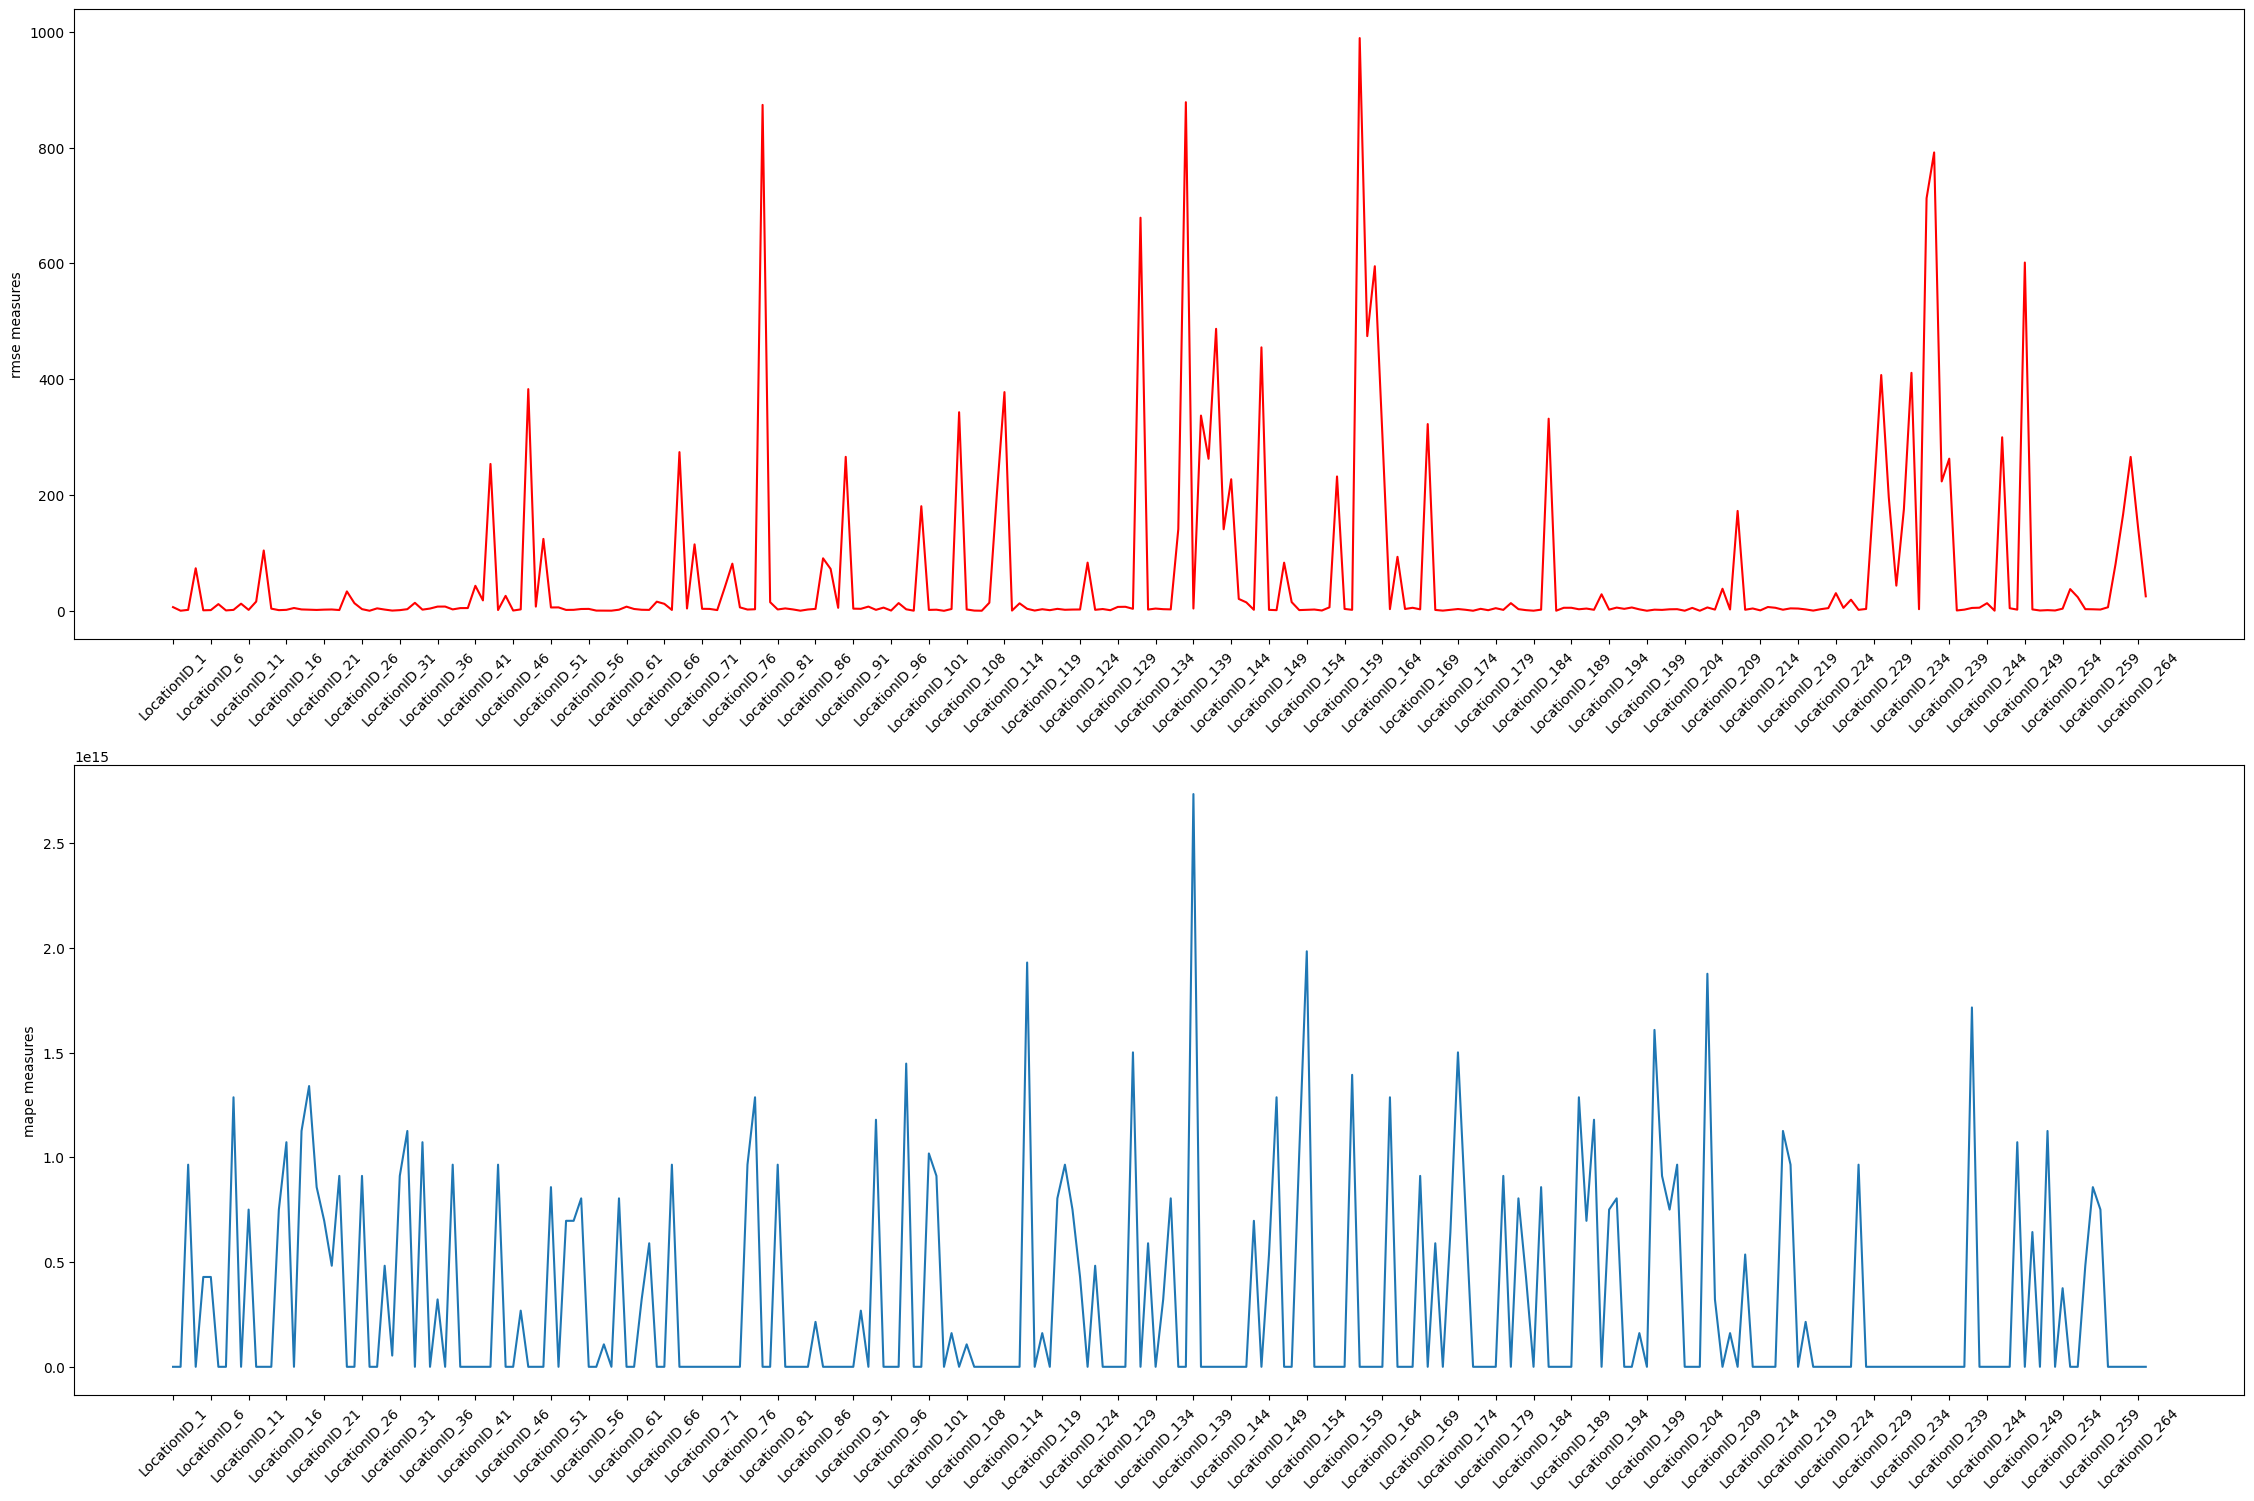

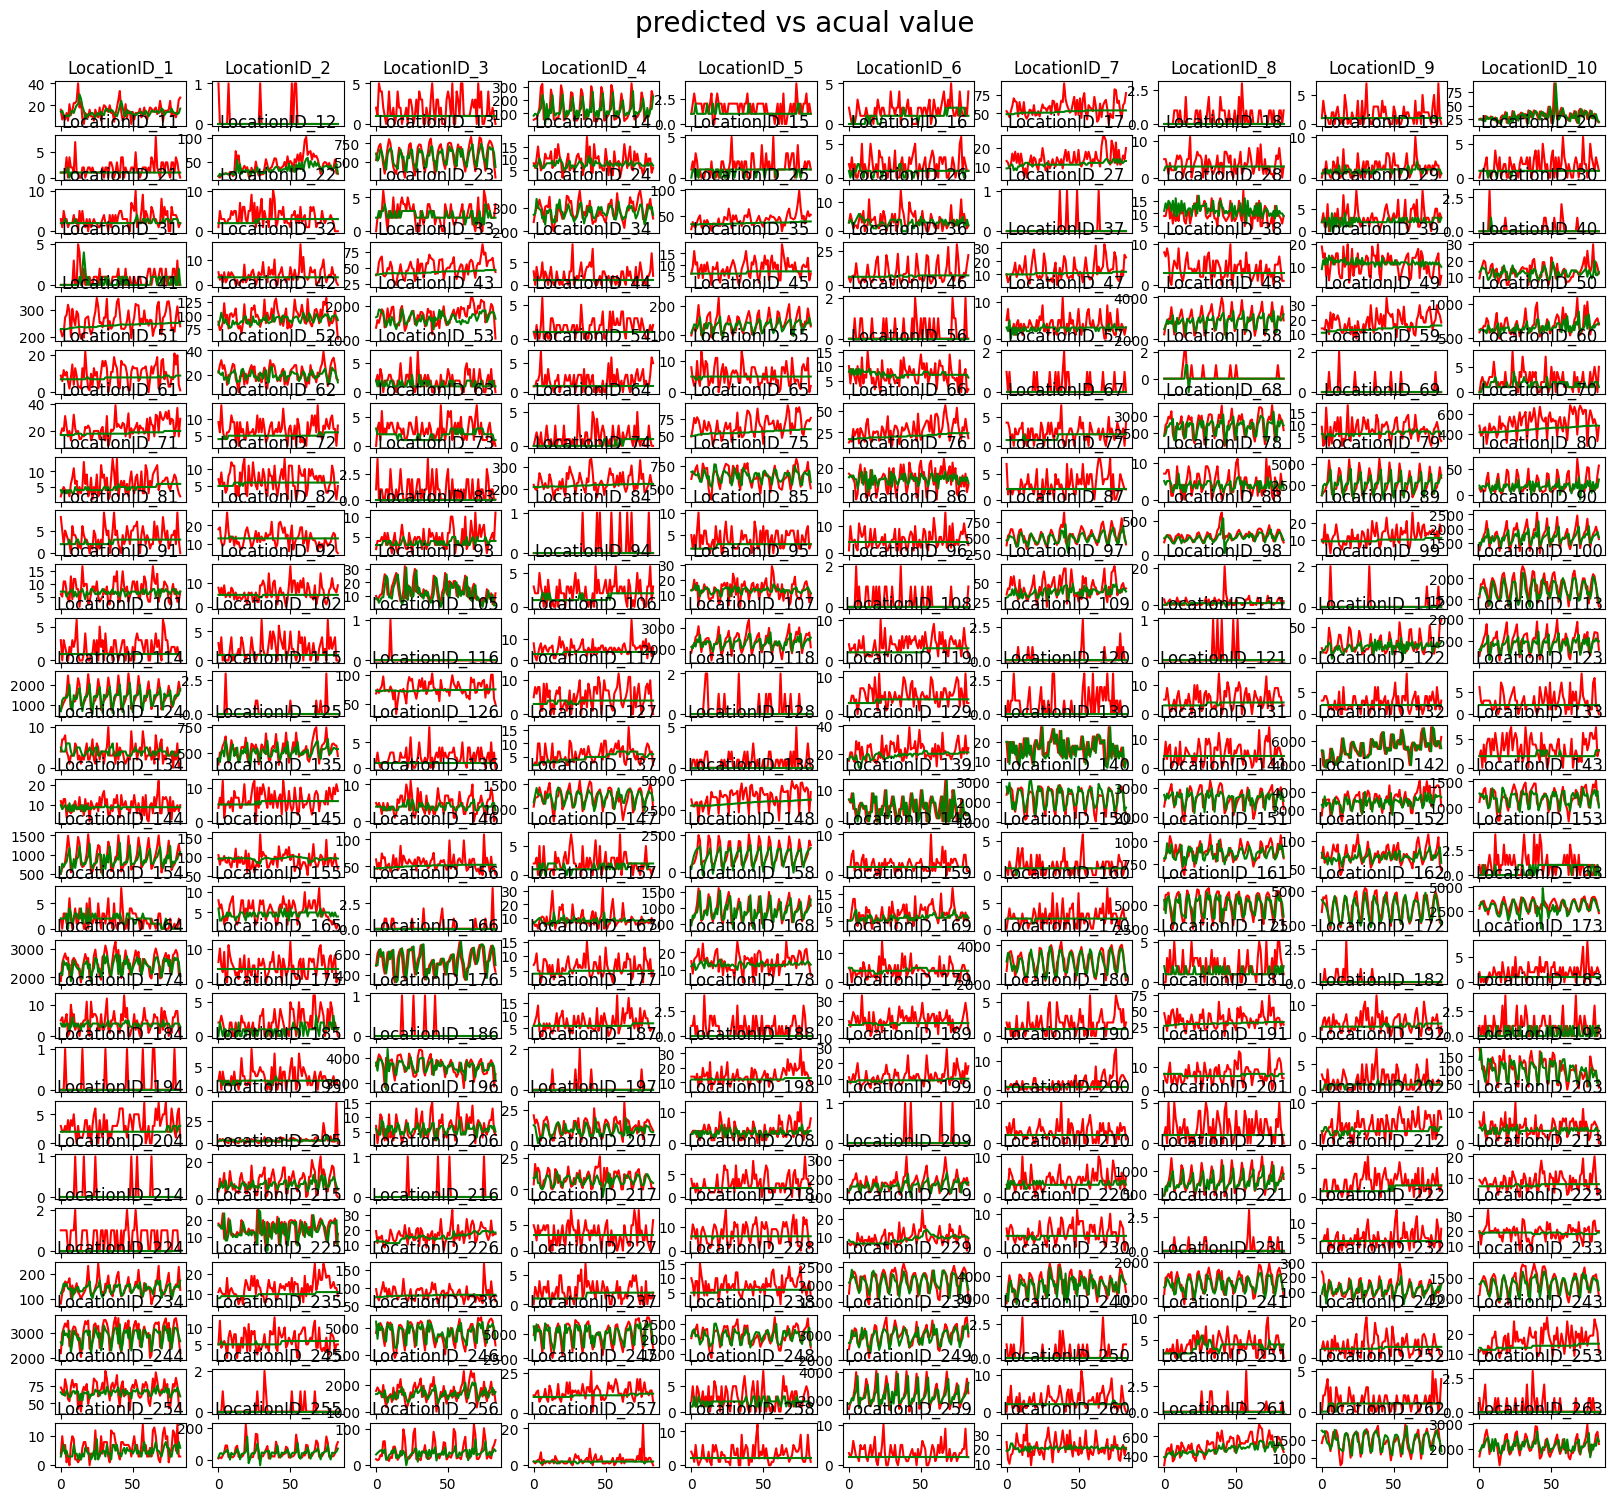

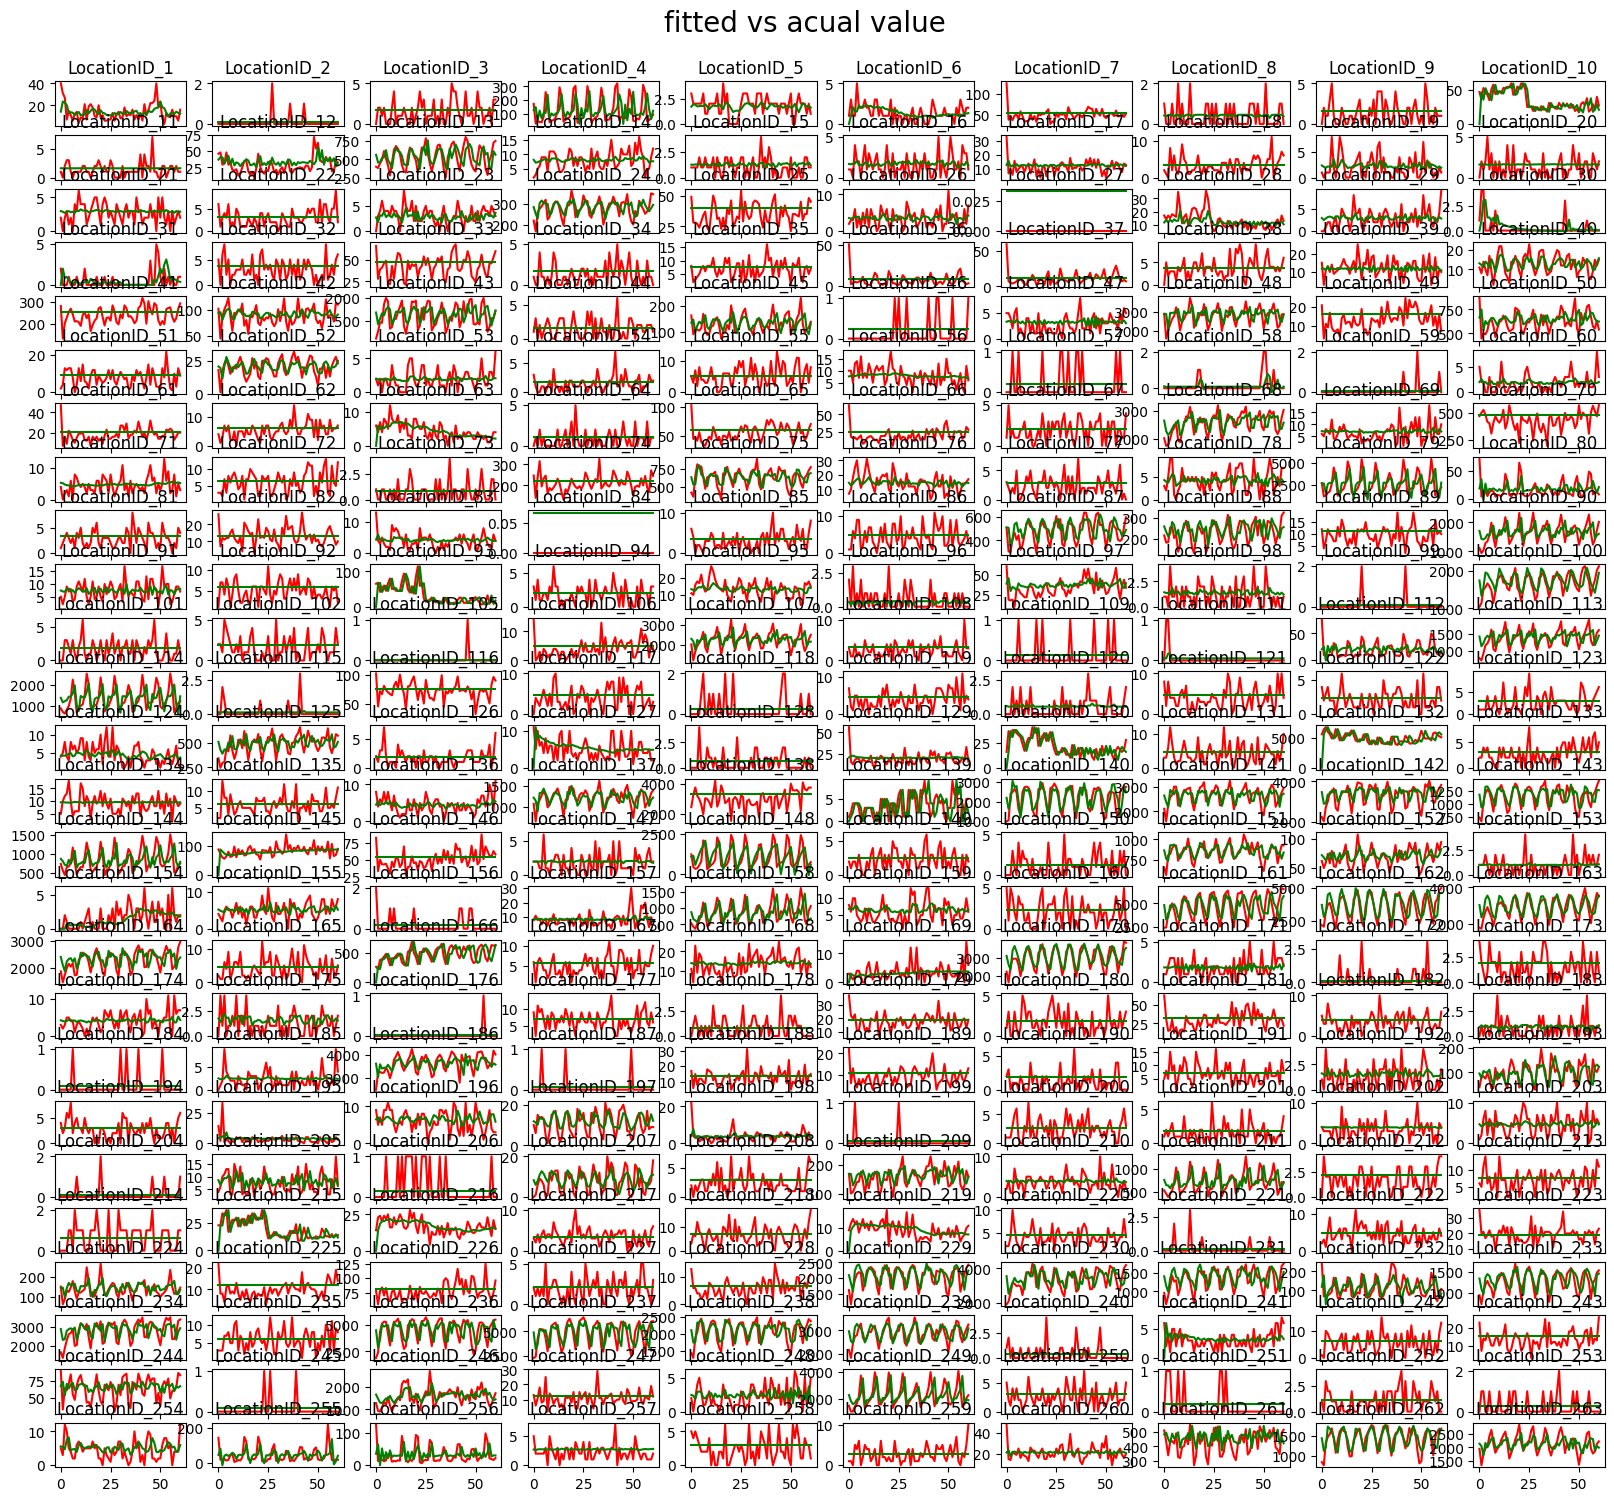

In [31]:
prediction_visualization(val_test, val_predicted, val_fit, all_loc_rmse, all_loc_mape, loc_labels_df)